# TESTS MODELES STANDARDS

## I- Création des classes et méthodes de calculs

In [68]:
import numpy as np
from scipy import *
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from math import *
from classes import *    

# Tests 

In [69]:
Km,Gm,Kf,Gf=10,10,110,110
f = 0.5
inclusion=Inclusion(0, {"K":Kf, "G":Gf})
microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
Bounds=microstructure.Hashin_bounds()
Ch=Differential_Scheme().compute_h_behavior(microstructure)
print(Ch)
Ch=Mori_Tanaka().compute_h_behavior(microstructure)
print(Ch)
Ch=Eshelby_Approximation().compute_h_behavior(microstructure)
print(Ch)
Km,Gm,Kf,Gf=10,10,105,105
f = 1
inclusion=Inclusion(0, {"K":Kf, "G":Gf})
microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})

{'K': 29.432550477380342, 'G': 26.958119812195473, 'E': 61.95799066921165, 'nu': 0.14915266904449928}
{'K': 25.909090909090907, 'G': 24.0, 'E': 55.01340482573727, 'nu': 0.14611260053619302}
{'K': 19.45945945945946, 'G': 18.13953488372093, 'E': 41.517989157220306, 'nu': 0.14440611138491868}


## Cas poreux pour les différents schémas

In [70]:
## Données
FMT =  [0.0135, 0.0168, 0.0202, 0.0236, 0.0269, 0.0336, 0.0337, 0.0404, 0.0437, 0.0471, 0.0505, 0.0538, 0.0572, 0.0606, 0.0639, 0.0673, 0.074, 0.0774, 0.0808, 0.0841, 0.0875, 0.0942, 0.0942, 0.1009, 0.1043, 0.1077, 0.1144, 0.1177, 0.1211, 0.1245, 0.1312, 0.1346, 0.1379, 0.1446, 0.148, 0.1514, 0.1547, 0.1615, 0.1648, 0.1715, 0.1749, 0.1783, 0.185, 0.1883, 0.1951, 0.1984, 0.2018, 0.2085, 0.2119, 0.2186, 0.2219, 0.2287, 0.232, 0.2387, 0.2421, 0.2488, 0.2522, 0.2589, 0.2656, 0.269, 0.2757, 0.2791, 0.2858, 0.2925, 0.2958, 0.3026, 0.3093, 0.316, 0.3193, 0.3261, 0.3328, 0.3395, 0.3428, 0.3496, 0.3563, 0.363, 0.3697, 0.373, 0.3764, 0.3798, 0.3865, 0.3932, 0.3965, 0.4032, 0.41, 0.4167, 0.42, 0.4234, 0.4301, 0.4368, 0.4368, 0.4402, 0.4469, 0.4536, 0.4603, 0.4637, 0.4703, 0.4771, 0.4838, 0.4905, 0.4971, 0.5039, 0.5106, 0.5173, 0.524, 0.5307, 0.5373, 0.5441, 0.5509, 0.5575, 0.5643, 0.571, 0.5777, 0.5844, 0.5911, 0.5977, 0.6045, 0.6112, 0.6179, 0.6246, 0.6313, 0.638, 0.6414, 0.6481, 0.6548, 0.6615, 0.6649, 0.6716, 0.6783, 0.685, 0.6917, 0.6984, 0.705, 0.7118, 0.7185, 0.7252, 0.7319, 0.7386, 0.742, 0.7487, 0.7553, 0.7621, 0.7688, 0.7755, 0.7822, 0.7889, 0.7955, 0.8023, 0.8056, 0.8124, 0.8191, 0.8258, 0.8325, 0.8357, 0.8425, 0.8492, 0.8526, 0.8593, 0.866, 0.8727, 0.8794, 0.8827, 0.8894, 0.8961, 0.9028, 0.9062, 0.9129, 0.9196, 0.9263, 0.933, 0.9397, 0.9464, 0.9531, 0.9564, 0.963, 0.9665]
KMT =  [0.9763, 0.9695, 0.9627, 0.956, 0.9492, 0.9424, 0.9357, 0.9289, 0.9221, 0.9153, 0.9085, 0.9018, 0.895, 0.8881, 0.8815, 0.8747, 0.8679, 0.8611, 0.8544, 0.8476, 0.8408, 0.834, 0.8273, 0.8205, 0.8136, 0.807, 0.8002, 0.7934, 0.7866, 0.7799, 0.7731, 0.7663, 0.7596, 0.7528, 0.746, 0.7391, 0.7325, 0.7257, 0.7189, 0.7122, 0.7054, 0.6985, 0.6918, 0.6851, 0.6783, 0.6715, 0.6646, 0.658, 0.6512, 0.6444, 0.6377, 0.6309, 0.624, 0.6174, 0.6106, 0.6038, 0.597, 0.5903, 0.5835, 0.5767, 0.5699, 0.5632, 0.5564, 0.5495, 0.5429, 0.5361, 0.5293, 0.5226, 0.5158, 0.509, 0.5023, 0.4955, 0.4887, 0.4819, 0.4752, 0.4684, 0.4616, 0.4583, 0.4549, 0.4481, 0.4413, 0.4413, 0.438, 0.4312, 0.4243, 0.4177, 0.4143, 0.4109, 0.4041, 0.3974, 0.3906, 0.3872, 0.3804, 0.377, 0.3703, 0.3669, 0.3669, 0.3601, 0.3534, 0.3466, 0.3397, 0.3364, 0.3296, 0.3229, 0.3161, 0.3128, 0.306, 0.2992, 0.2958, 0.2891, 0.2823, 0.2755, 0.2722, 0.2654, 0.262, 0.2553, 0.2519, 0.2451, 0.2383, 0.2349, 0.2282, 0.2248, 0.2214, 0.218, 0.2113, 0.2079, 0.2045, 0.2011, 0.1944, 0.191, 0.1842, 0.1808, 0.1775, 0.1707, 0.1673, 0.1639, 0.1572, 0.1538, 0.1504, 0.147, 0.1437, 0.1369, 0.1335, 0.1301, 0.1234, 0.12, 0.1166, 0.1132, 0.1098, 0.1065, 0.1031, 0.0963, 0.0929, 0.0896, 0.0896, 0.0828, 0.0794, 0.0794, 0.0727, 0.0693, 0.0659, 0.0625, 0.0625, 0.0558, 0.0524, 0.049, 0.049, 0.0422, 0.0422, 0.0355, 0.0321, 0.0287, 0.0253, 0.022, 0.0186, 0.0152]
FDIF =  [0.0103, 0.0137, 0.0172, 0.0206, 0.0241, 0.0275, 0.0309, 0.0344, 0.0378, 0.0412, 0.0447, 0.0481, 0.0515, 0.055, 0.0584, 0.0619, 0.0653, 0.0722, 0.0756, 0.079, 0.0825, 0.0859, 0.0893, 0.0928, 0.0962, 0.0997, 0.1031, 0.1065, 0.1134, 0.1168, 0.1203, 0.1237, 0.1271, 0.1306, 0.134, 0.1409, 0.1443, 0.1478, 0.1512, 0.1546, 0.1581, 0.1649, 0.1684, 0.1718, 0.1753, 0.1787, 0.1856, 0.189, 0.1924, 0.1993, 0.2027, 0.2062, 0.2096, 0.2165, 0.2199, 0.2234, 0.2268, 0.2337, 0.2371, 0.2405, 0.2474, 0.2509, 0.2543, 0.2612, 0.2646, 0.268, 0.2749, 0.2784, 0.2818, 0.2887, 0.2921, 0.299, 0.3024, 0.3093, 0.3127, 0.3195, 0.323, 0.3299, 0.3333, 0.3402, 0.3436, 0.3505, 0.354, 0.3608, 0.3643, 0.3711, 0.3746, 0.3814, 0.3849, 0.3918, 0.3952, 0.4021, 0.4055, 0.4123, 0.4192, 0.4261, 0.4296, 0.4364, 0.4433, 0.4502, 0.4536, 0.4605, 0.4674, 0.4742, 0.4811, 0.4845, 0.488, 0.4948, 0.4948, 0.5017, 0.5051, 0.512, 0.5154, 0.5223, 0.5292, 0.5361, 0.5394, 0.5464, 0.5497, 0.5533, 0.5601, 0.5636, 0.5704, 0.5773, 0.5842, 0.5911, 0.5979, 0.6048, 0.6117, 0.6186, 0.6254, 0.6322, 0.6392, 0.646, 0.6529, 0.6598, 0.6667, 0.6735, 0.6804, 0.6873, 0.6942, 0.701, 0.7079, 0.7147, 0.7216, 0.7285, 0.7354, 0.7423, 0.749, 0.756, 0.7629, 0.7698, 0.7766, 0.7835, 0.7904, 0.7973, 0.8041, 0.811, 0.8178, 0.8247, 0.8316, 0.8385, 0.8454, 0.8521, 0.8591, 0.866, 0.8729]
KDIF =  [0.9742, 0.9673, 0.9639, 0.9569, 0.9501, 0.9433, 0.9364, 0.9295, 0.9226, 0.9157, 0.9089, 0.902, 0.8951, 0.8881, 0.8813, 0.8745, 0.8676, 0.8607, 0.8538, 0.8469, 0.8401, 0.8332, 0.8263, 0.8194, 0.8125, 0.8056, 0.7988, 0.7919, 0.785, 0.7781, 0.7713, 0.7644, 0.7574, 0.7506, 0.7437, 0.7368, 0.73, 0.7231, 0.7162, 0.7093, 0.7024, 0.6955, 0.6886, 0.6818, 0.6749, 0.668, 0.6611, 0.6543, 0.6474, 0.6404, 0.6336, 0.6267, 0.6198, 0.613, 0.6061, 0.5992, 0.5923, 0.5854, 0.5785, 0.5716, 0.5648, 0.5579, 0.551, 0.5441, 0.5372, 0.5304, 0.5234, 0.5166, 0.5097, 0.5028, 0.4959, 0.4889, 0.4821, 0.4753, 0.4684, 0.4615, 0.4546, 0.4477, 0.4408, 0.4339, 0.427, 0.4202, 0.4133, 0.4064, 0.3995, 0.3926, 0.3857, 0.3788, 0.3719, 0.3685, 0.3616, 0.3547, 0.3477, 0.3409, 0.334, 0.3271, 0.3203, 0.3134, 0.3065, 0.2995, 0.2927, 0.2858, 0.2789, 0.272, 0.2651, 0.2617, 0.2582, 0.2582, 0.2513, 0.2478, 0.2444, 0.2375, 0.2341, 0.2272, 0.2237, 0.2168, 0.2099, 0.2065, 0.1996, 0.1961, 0.1927, 0.1892, 0.1857, 0.1788, 0.172, 0.1685, 0.1616, 0.1547, 0.1512, 0.1443, 0.1409, 0.134, 0.1305, 0.1236, 0.1201, 0.1167, 0.1098, 0.1063, 0.1028, 0.0959, 0.0925, 0.089, 0.0856, 0.0821, 0.0752, 0.0717, 0.0683, 0.0648, 0.0613, 0.0579, 0.0544, 0.0509, 0.0475, 0.044, 0.0405, 0.0405, 0.037, 0.0336, 0.0301, 0.0301, 0.0266, 0.0231, 0.0197, 0.0196, 0.0196, 0.0161, 0.0127]
KHMT,KHDIF = [],[]

for i in range(len(FMT)):   
    f=FMT[i]
    Em=3
    mum=0
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    K=0
    G=0
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    Ch=Mori_Tanaka().compute_h_behavior(microstructure)
    Kh=Ch['K']/Km
    KHMT.append(Kh)
    
for i in range(len(FDIF)): 
    f=FDIF[i]
    Em=10
    mum=0
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    K=0
    G=0
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    Ch=Differential_Scheme().compute_h_behavior(microstructure)
    Kh=Ch['K']/Km
    KHDIF.append(Kh)

plt.plot(FMT,KHMT,label='Schema')
plt.plot(FMT,KMT,':',label='reference')
plt.legend()
plt.show()

plt.plot(FDIF,KHDIF,label='Schema')
plt.plot(FDIF,KDIF,':',label='reference')
plt.legend()
plt.show()
   

ZeroDivisionError: division by zero

## Modèle d'Eshelby

### PROBLEME LE RESULTAT SORT TOUJOURS DES BORNES DE H-S

### Inclusion rigide

Référence : simplification de la formule : à trouver dans la littérature

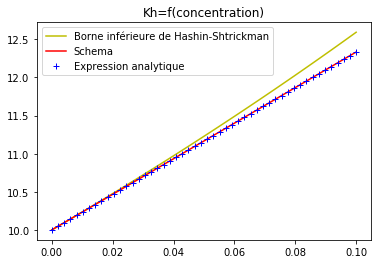

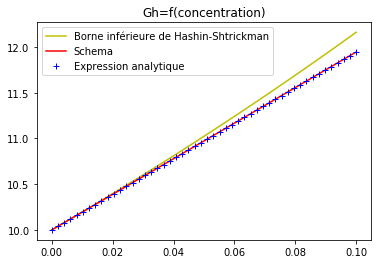

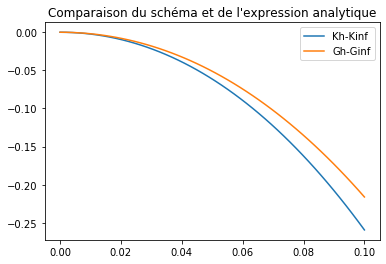

In [74]:
F=np.linspace(0,0.1,50)
Km,Gm,Kf,Gf=10,10,10**15,10**15
KEsh,GEsh,Kform,Gform=[],[],[],[]
Kinf,Ksup,Gsup,Ginf = [],[],[],[]

for i in range(len(F)):
    f=F[i]
    inclusion=Inclusion(0, {"K":Kf, "G":Gf}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Eshelby_Approximation()
    Ch=model.compute_h_behavior(microstructure)
    KEsh.append(Ch['K'])
    GEsh.append(Ch['G'])
    
    k=Km+f*(3*Km+4*Gm)/3
    g=Gm+5*f*Gm*(3*Km+4*Gm)/(6*Km+12*Gm)
    Kform.append(k)
    Gform.append(g)    
    
    Bounds=microstructure.Hashin_bounds()
    Gsup.append(Bounds['Gsup'])
    Ginf.append(Bounds['Ginf'])
    Ksup.append(Bounds['Ksup'])
    Kinf.append(Bounds['Kinf'])




plt.plot(F,Kinf,'y',label='Borne inférieure de Hashin-Shtrickman')
plt.plot(F,KEsh,'r',label='Schema')
plt.plot(F,Kform,'+b',label='Expression analytique')
plt.legend()
plt.title("Kh=f(concentration)")
plt.show()


plt.plot(F,Ginf,'y',label='Borne inférieure de Hashin-Shtrickman')
plt.plot(F,GEsh,'r',label='Schema')
plt.plot(F,Gform,'+b',label='Expression analytique')
plt.title("Gh=f(concentration)")
plt.legend()
plt.show()

Gdiff = np.array(GEsh)-np.array(Ginf)
Kdiff = np.array(KEsh)-np.array(Kinf) 
plt.plot(F,Kdiff,label='Kh-Kinf')
plt.plot(F,Gdiff,label='Gh-Ginf')
plt.legend()
plt.title("Comparaison du schéma et de l'expression analytique")
plt.show()

## Inclusion rigide et matrice incompressible

Reference : formule simplifiée

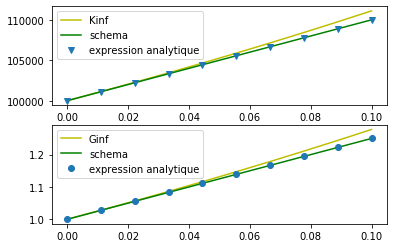

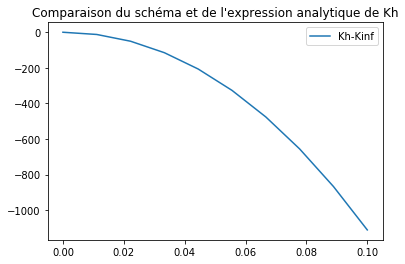

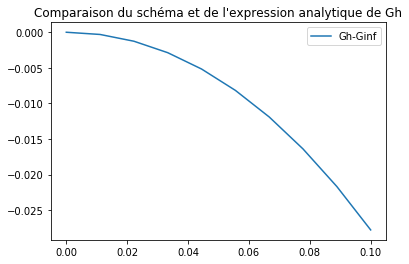

In [29]:
F=np.linspace(0,0.1,10)
Km,Gm,Kf,Gf=100000,1,10**15,10**15
KEsh,GEsh,Kform,Gform=[],[],[],[]
Kinf,Ksup,Gsup,Ginf = [],[],[],[]

for i in range(len(F)):
    f=F[i]
    inclusion=Inclusion(0, {"K":Kf, "G":Gf}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Eshelby_Approximation()
    Ch=model.compute_h_behavior(microstructure)
    KEsh.append(Ch['K'])
    GEsh.append(Ch['G'])
    
    k=Km+f*Km
    g=Gm+5*f*Gm/2
    Kform.append(k)
    Gform.append(g)    
    
    Bounds=microstructure.Hashin_bounds()
    Gsup.append(Bounds['Gsup'])
    Ginf.append(Bounds['Ginf'])
    Ksup.append(Bounds['Ksup'])
    Kinf.append(Bounds['Kinf'])



plt.plot(F,Kinf,'y',label='Borne inférieure de Hashin-Shtrickman')
plt.plot(F,KEsh,'g',label='schema')
plt.plot(F,Kform,'v',label='expression analytique')
plt.legend()

plt.show()

plt.plot(F,Ginf,'y',label='Borne inférieure de Hashin-Shtrickman')
plt.plot(F,GEsh,'g',label='schema')
plt.plot(F,Gform,'o',label='expression analytique')
plt.legend()
plt.show()

Gdiff = np.array(GEsh)-np.array(Ginf)
Kdiff = np.array(KEsh)-np.array(Kinf) 
plt.plot(F,Kdiff,label='Kh-Kinf')
plt.legend()
plt.title("Comparaison du schéma et de l'expression analytique de Kh")
plt.show()

plt.plot(F,Gdiff,label='Gh-Ginf')
plt.legend()
plt.title("Comparaison du schéma et de l'expression analytique de Gh")
plt.show()

## Schéma Différentiel

### Comparaison intégrale/itération

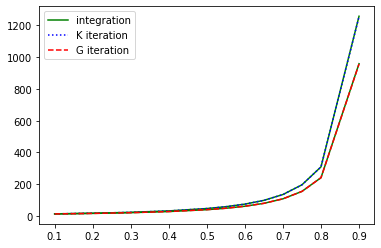

In [6]:
npoints=10000
F=[0.1,0.2,0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.9]
Km,Gm,Kf,Gf=10,10,10**15,10**15
KH,GH,KT,GT=[],[],[],[]

for i in range(len(F)):
    f=F[i]
    inclusion=Inclusion(0, {"K":Kf, "G":Gf}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Differential_Scheme()
    Ch=model.compute_h_behavior(microstructure)
    KH.append(Ch['K'])
    GH.append(Ch['G'])
    
    dc=f/npoints
    K,G=Km,Gm
    c=0
    for i in range (npoints):
        dK,dG,dKf,dGf=Differential_Scheme.deriv([K,G,Kf,Gf],c)
        K+=dc*dK
        G+=dc*dG
        c+=dc
    KT.append(K)
    GT.append(G)    

plt.plot(F,KH,'g',label='integration')
plt.plot(F,KT,':b',label='K iteration')
plt.plot(F,GH,'g')
plt.plot(F,GT,'--r',label='G iteration')
plt.legend()
plt.show()

### Inclusion parfaitement rigide et concentration pas trop élevée

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Equation (7) and (8) p5

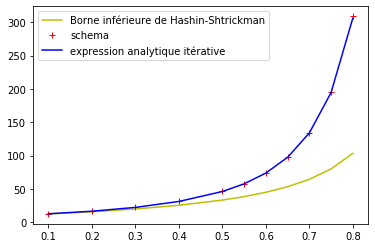

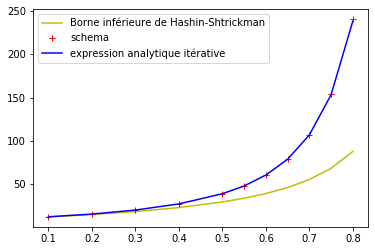

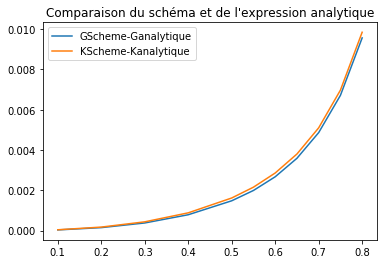

In [35]:
npoints=1000
F=[0.1,0.2,0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.75,0.8]
Km,Gm,Kf,Gf=10,10,10**15,10**15
KScheme,GScheme,Kit,Git=[],[],[],[]
Kinf,Ksup,Gsup,Ginf = [],[],[],[]

def SuivantInclusionRigide(k,g,c,dc):
    nextk=k+dc*(k+4*g/3)/(1-c)
    nextg=g+dc*5*g*(3*k+4*g)/(6*(k+2*g)*(1-c))
    return nextk,nextg,c+dc

for i in range(len(F)):
    f=F[i]
    inclusion=Inclusion(0, {"K":Kf, "G":Gf}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Differential_Scheme()
    Ch=model.compute_h_behavior(microstructure)

    dc=f/npoints
    k,K,g,G=Km,Gm,Km,Gm
    c=0
    for i in range (npoints):
        k,g,c=SuivantInclusionRigide(k,g,c,dc)
    KScheme.append(Ch['K'])
    GScheme.append(Ch['G'])
    Kit.append(k)
    Git.append(g)    
    
    Bounds=microstructure.Hashin_bounds()
    Gsup.append(Bounds['Gsup'])
    Ginf.append(Bounds['Ginf'])
    Ksup.append(Bounds['Ksup'])
    Kinf.append(Bounds['Kinf'])



plt.plot(F,Kinf,'y',label='Borne inférieure de Hashin-Shtrickman')
plt.plot(F,KScheme,'+r',label='schema')
plt.plot(F,Kit,'b',label='expression analytique itérative')
plt.legend()
plt.show()

plt.plot(F,Ginf,'y',label='Borne inférieure de Hashin-Shtrickman')
plt.plot(F,GScheme,'+r',label='schema')
plt.plot(F,Git,'b',label='expression analytique itérative')
plt.legend()
plt.show()

Gdiff = (np.array(GScheme)-np.array(Git))/np.array(Git)
Kdiff = (np.array(KScheme)-np.array(Kit))/np.array(Kit) 
plt.plot(F,Gdiff,label='GScheme-Ganalytique')
plt.plot(F,Kdiff,label='KScheme-Kanalytique')
plt.legend()
plt.title("Comparaison du schéma et de l'expression analytique")
plt.show()

### Inclusion rigide et matrice incompressible et concentration pas trop élevée

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Equation (12) and (13) p6

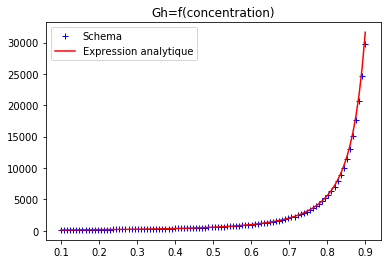

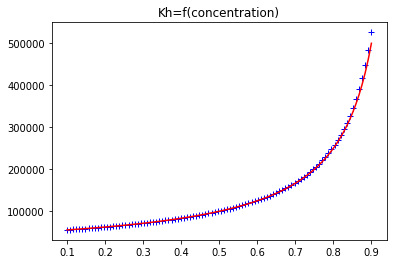

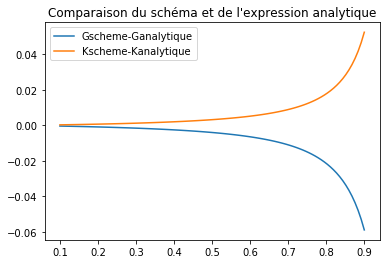

In [39]:
F=np.linspace(0.1,0.9,100)
LK=[]
LKT=[]
LG=[]
LGT=[]
for i in range(len(F)):
    f=F[i]
    Em=300
    mum=0.499
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    K=2*10**9
    G=3*10**9
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Differential_Scheme()
    Ch=model.compute_h_behavior(microstructure)
    LK.append(Ch['K'])
    LG.append(Ch['G'])
    LGT.append(Gm/(1-f)**(5/2))
    LKT.append(Km/(1-f))



plt.plot(F,LG,'+b',label='Schema')
plt.plot(F,LGT,'r',label='Expression analytique')
plt.legend()
plt.title("Gh=f(concentration)")
plt.show()

plt.plot(F,LK,'+b',label='Schema')
plt.plot(F,LKT,'r',label='Expression analytique')
plt.legend()
plt.title("Kh=f(concentration)")
plt.show()

Gdiff = (np.array(LG)-np.array(LGT))/np.array(LGT)
Kdiff = (np.array(LK)-np.array(LKT))/np.array(LKT) 
plt.plot(F,Gdiff,label='Gscheme-Ganalytique')
plt.plot(F,Kdiff,label='Kscheme-Kanalytique')
plt.legend()
plt.title("Comparaison du schéma et de l'expression analytique")
plt.show()

### Inclusion rigide, mu=0,2 et concentration pas trop élevée

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Equation (19) p7

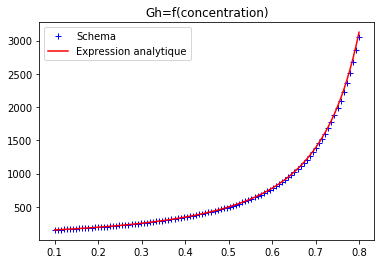

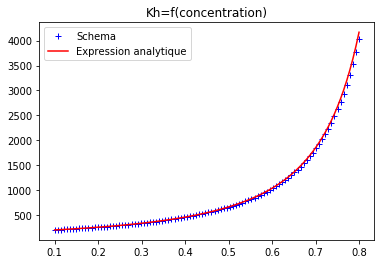

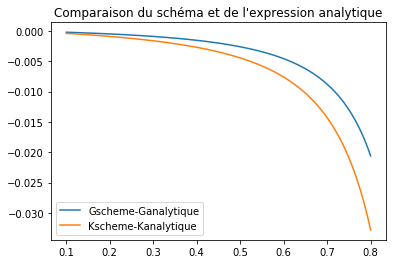

In [42]:
F=np.linspace(0.1,0.8,100)
LK=[]
LKT=[]
LG=[]
LGT=[]
for i in range(len(F)):
    f=F[i]
    Em=300
    mum=0.2
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    K=2*10**5
    G=3*10**5
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Differential_Scheme()
    Ch=model.compute_h_behavior(microstructure)
    LK.append(Ch['K'])
    LG.append(Ch['G'])
    LGT.append(Gm/(1-f)**2)
    LKT.append(Km/(1-f)**2)

plt.plot(F,LG,'+b',label='Schema')
plt.plot(F,LGT,'r',label='Expression analytique')
plt.legend()
plt.title("Gh=f(concentration)")
plt.show()

plt.plot(F,LK,'+b',label='Schema')
plt.plot(F,LKT,'r',label='Expression analytique')
plt.legend()
plt.title("Kh=f(concentration)")
plt.show()

Gdiff = (np.array(LG)-np.array(LGT))/np.array(LGT)
Kdiff = (np.array(LK)-np.array(LKT))/np.array(LKT) 
plt.plot(F,Gdiff,label='Gscheme-Ganalytique')
plt.plot(F,Kdiff,label='Kscheme-Kanalytique')
plt.legend()
plt.title("Comparaison du schéma et de l'expression analytique")
plt.show()

### Haute concentration et matrice incompressible inclusion parfaitement rigide

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Equation (29) p8

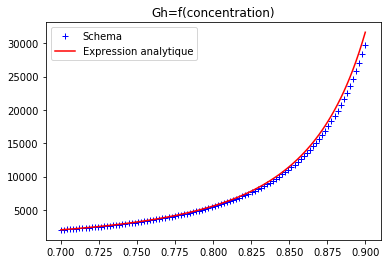

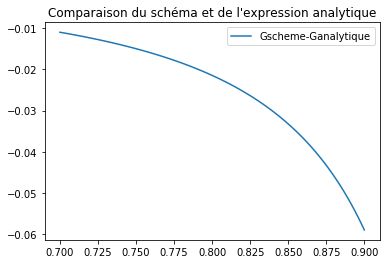

In [43]:
F=np.linspace(0.7,0.9,100)
LK=[]
LKT=[]
LG=[]
LGT=[]
for i in range(len(F)):
    f=F[i]
    Em=300
    mum=0.499
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    K=10**15
    G=10**15
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Differential_Scheme()
    Ch=model.compute_h_behavior(microstructure)
    LG.append(Ch['G'])
    LGT.append(Gm/(1-f)**(5/2))

    
plt.plot(F,LG,'+b',label='Schema')
plt.plot(F,LGT,'r',label='Expression analytique')
plt.legend()
plt.title("Gh=f(concentration)")
plt.show()

Gdiff = (np.array(LG)-np.array(LGT))/np.array(LGT)
plt.plot(F,Gdiff,label='Gscheme-Ganalytique')
plt.legend()
plt.title("Comparaison du schéma et de l'expression analytique")
plt.show()

# Schéma de Mori-Tanaka
### Inclusion rigide

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Equation (64) p15

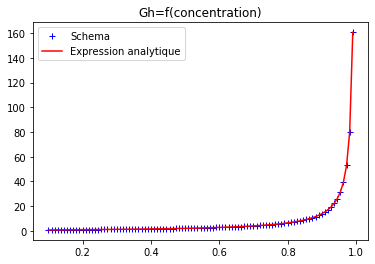

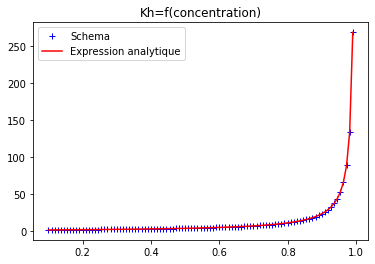

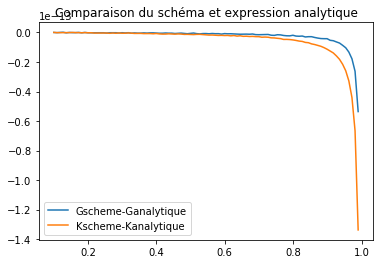

In [49]:
F=np.linspace(0.1,0.99,99)
LK=[]
LKT=[]
LG=[]
LGT=[]
for i in range(1,100):
    f=i/100
    Em=2
    mum=0.3
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    K=2*10**15
    G=3*10**15
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Mori_Tanaka()
    Ch=model.compute_h_behavior(microstructure)
    LK.append(Ch['K'])
    LG.append(Ch['G'])
    LGT.append(Gm*(1+f/(1-f)*(1+(9*Km+8*Gm)/(6*Km+12*Gm))))
    LKT.append(Km*(1+f/(1-f)*(1+4*Gm/(3*Km))))
    
plt.plot(F,LG,'+b',label='Schema')
plt.plot(F,LGT,'r',label='Expression analytique')
plt.legend()
plt.title("Gh=f(concentration)")
plt.show()

plt.plot(F,LK,'+b',label='Schema')
plt.plot(F,LKT,'r',label='Expression analytique')
plt.legend()
plt.title("Kh=f(concentration)")
plt.show()

Gdiff = (np.array(LG)-np.array(LGT))/np.array(LGT)
Kdiff = (np.array(LK)-np.array(LKT))/np.array(LKT) 
plt.plot(F,Gdiff,label='Gscheme-Ganalytique')
plt.plot(F,Kdiff,label='Kscheme-Kanalytique')
plt.legend()
plt.title("Comparaison du schéma et expression analytique")
plt.show()


### Inclusion rigide et matrice incompressible

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Equation (65) p15

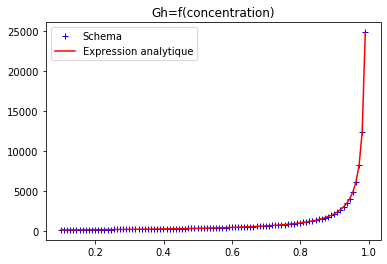

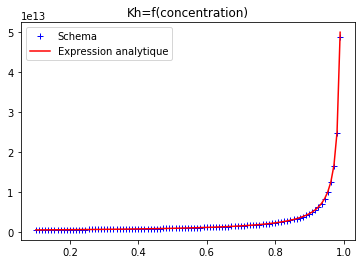

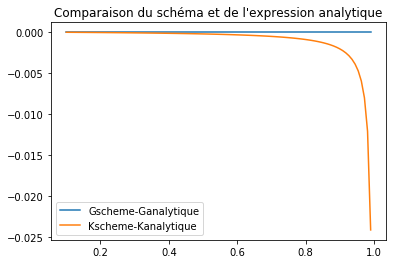

In [50]:
F=np.linspace(0.1,0.99,99)
LK=[]
LKT=[]
LG=[]
LGT=[]
for i in range(1,100):
    f=i/100
    Em=300
    mum=0.4999999999
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    K=2*10**15
    G=3*10**15
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Mori_Tanaka()
    Ch=model.compute_h_behavior(microstructure)
    LK.append(Ch['K'])
    LG.append(Ch['G'])
    LGT.append(Gm*(1+3*f/2)/(1-f))
    LKT.append(Km/(1-f))
    
plt.plot(F,LG,'+b',label='Schema')
plt.plot(F,LGT,'r',label='Expression analytique')
plt.legend()
plt.title("Gh=f(concentration)")
plt.show()

plt.plot(F,LK,'+b',label='Schema')
plt.plot(F,LKT,'r',label='Expression analytique')
plt.legend()
plt.title("Kh=f(concentration)")
plt.show()

Gdiff = (np.array(LG)-np.array(LGT))/np.array(LGT)
Kdiff = (np.array(LK)-np.array(LKT))/np.array(LKT) 
plt.plot(F,Gdiff,label='Gscheme-Ganalytique')
plt.plot(F,Kdiff,label='Kscheme-Kanalytique')
plt.legend()
plt.title("Comparaison du schéma et de l'expression analytique")
plt.show()

### Concentration élévées (f->1) et matrice compressible

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Table 2 p16

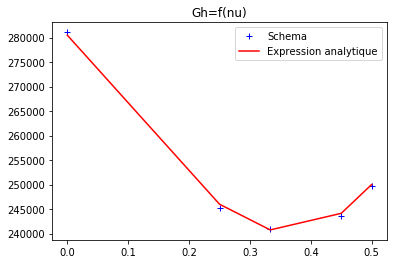

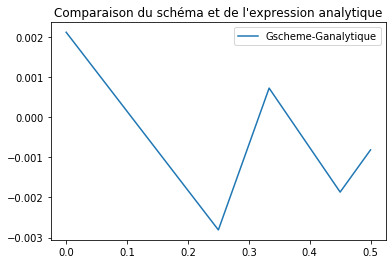

In [53]:
Nu=[0,1/4,1/3,0.45,0.4999]
Alpha=[1.87,2.05,2.14,2.36,2.5]
LG=[]
LGT=[]

for i in range(len(Nu)):
    f=0.999
    Em=300
    num=Nu[i]
    Km=Em/(3-6*num)
    Gm=Em/(2+2*num)
    K=2*10**9
    G=3*10**9
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Mori_Tanaka()
    Ch=model.compute_h_behavior(microstructure)
    LG.append(Ch['G'])
    LGT.append(Gm*Alpha[i]/(1-f))
    
plt.plot(Nu,LG,'+b',label='Schema')
plt.plot(Nu,LGT,'r',label='Expression analytique')
plt.legend()
plt.title("Gh=f(nu)")
plt.show()


Gdiff = (np.array(LG)-np.array(LGT))/np.array(LGT)
plt.plot(Nu,Gdiff,label='Gscheme-Ganalytique')
plt.legend()
plt.title("Comparaison du schéma et de l'expression analytique")
plt.show()

### Cas particulier : mu=1/5, inclusion rigide comparaison des modèles Mori-Tanaka et Differentiel

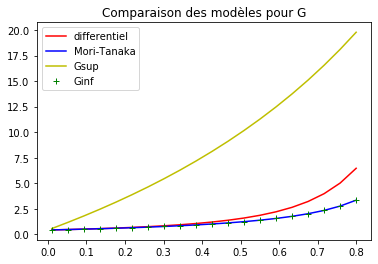

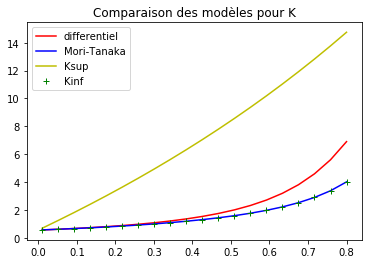

In [67]:
F=np.linspace(0.01,0.8,20)
Kdiff,Gdiff, KMT,GMT,Kinf,Ksup,Gsup,Ginf = [],[],[],[],[],[],[],[]
for i in range(len(F)):
    f=F[i]
    Em=1
    num=0.2
    Km=Em/(3-6*num)
    Gm=Em/(2+2*num)
    K=20
    G=30
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    Bounds=microstructure.Hashin_bounds()
    Gsup.append(Bounds['Gsup'])
    Ginf.append(Bounds['Ginf'])
    Ksup.append(Bounds['Ksup'])
    Kinf.append(Bounds['Kinf'])
    
    modeldiff = Differential_Scheme()
    Chdiff=modeldiff.compute_h_behavior(microstructure)
    Kdiff.append(Chdiff['K'])
    Gdiff.append(Chdiff['G'])
    
    modelmt = Mori_Tanaka()
    Chmt = modelmt.compute_h_behavior(microstructure)
    GMT.append(Chmt['G'])
    KMT.append(Chmt['K'])
    

plt.title("Comparaison des modèles pour G")
plt.plot(F,Gdiff,'r',label='differentiel')
plt.plot(F,GMT,'b',label='Mori-Tanaka')
plt.plot(F,Gsup,'y',label='Gsup')
plt.plot(F,Ginf,'+g',label='Ginf')
plt.legend()
plt.show() 

plt.title("Comparaison des modèles pour K")
plt.plot(F,Kdiff,'r',label='differentiel')
plt.plot(F,KMT,'b',label='Mori-Tanaka')
plt.plot(F,Ksup,'y',label='Ksup')
plt.plot(F,Kinf,'+g',label='Kinf')
plt.legend()
plt.show()

## Bornes de Hashin-Shtrickman

### Test du modèle des bornes de Hashin-Shtrickman pour K,G>Km,Gm

Référence : [Hashin, Z., and Shtrikman, S., 1963.  A Variational Approach to the Theory of the Elastic Behaviour of Multiphase Materials.J. Mech.  Phys.  Solids, 11, 127–140].

Datas : Fig 1 and 2 p136

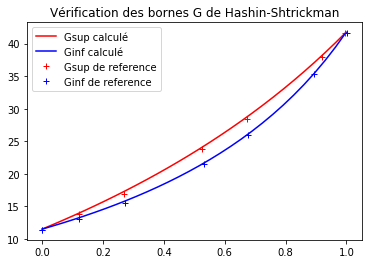

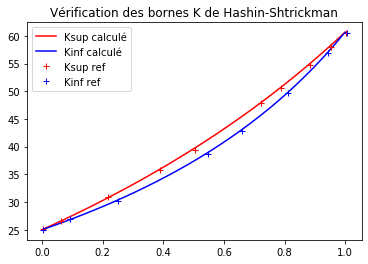

In [65]:
## Données : 
K,G = 60.7,41.8
Km,Gm = 25,11.5

FGinf = [0.000771508, 0.122418131, 0.272279371, 0.530682701, 0.676225717, 0.893925994, 1.000617946]
Ginf = [11.37606358, 13.08246844, 15.49789621, 21.45086489, 25.97007948, 35.35147265, 41.64721833]
FGsup = [0.000771508,0.120567993, 0.26919519, 0.526210916, 0.673759482, 0.919211841, 0.996917669]
Gsup = [11.37606358,13.83048153, 16.91603553, 23.81178121, 28.44787284, 38.00065451, 41.61608228]
FKinf = [0.00267784, 0.090936685, 0.249534451, 0.546089385, 0.657821229, 0.811297952, 0.944599628, 1.004189944]
Kinf = [24.95709828, 26.84864275, 30.24964119, 38.6349454, 42.82371295, 49.65678627, 56.8174727, 60.51482059]
FKsup = [0.004422719, 0.062849162, 0.217877095, 0.389664804, 0.502793296, 0.722843575, 0.788640596, 0.884078212, 0.954376164, 1.003724395]
Ksup =[25.0975039, 26.65366615, 30.88923557, 35.75663027, 39.38377535, 47.78471139, 50.54602184, 54.75819033, 58.01092044, 60.56939158]

F=np.linspace(0.0001,0.999,30)
kinf,ksup,gsup,ginf = [],[],[],[]
for i in range(len(F)):
    f = F[i]
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    Bounds=microstructure.Hashin_bounds()
    gsup.append(Bounds['Gsup'])
    ginf.append(Bounds['Ginf'])
    ksup.append(Bounds['Ksup'])
    kinf.append(Bounds['Kinf'])


plt.plot(F,gsup,'r',label='Gsup calculé')
plt.plot(F,ginf,'b',label='Ginf calculé')
plt.plot(FGsup,Gsup,'+r',label='Gsup de reference')
plt.plot(FGinf,Ginf,'+b',label='Ginf de reference')
plt.legend()
plt.title("Vérification des bornes G de Hashin-Shtrickman")
plt.show()

plt.plot(F,ksup,'r',label='Ksup calculé')
plt.plot(F,kinf,'b',label='Kinf calculé')
plt.plot(FKsup,Ksup,'+r',label='Ksup ref')
plt.plot(FKinf,Kinf,'+b',label='Kinf ref')
plt.title("Vérification des bornes K de Hashin-Shtrickman")
plt.legend()
plt.show()